## Import Libraries

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

2024-04-12 02:08:09.745607: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Clone & Explore dataset

In [4]:
!git clone https://github.com/education454/datasets.git

Cloning into 'datasets'...
remote: Enumerating objects: 2301, done.
remote: Total 2301 (delta 0), reused 0 (delta 0), pack-reused 2301
Receiving objects: 100% (2301/2301), 1.31 GiB | 39.25 MiB/s, done.
Updating files: 100% (2295/2295), done.


In [5]:
import os

main_dir = "/content/datasets/Data"
train_dir = os.path.join(main_dir, "train")
test_dir  = os.path.join(main_dir, "test")
train_covid_dir = os.path.join(train_dir, "COVID19")
train_normal_dir = os.path.join(train_dir, "NORMAL")
test_covid_dir = os.path.join(test_dir, "COVID19")
test_normal_dir = os.path.join(test_dir, "NORMAL")


In [6]:
train_covid_name = os.listdir(train_covid_dir)
train_normal_name = os.listdir(train_normal_dir)
test_covid_name = os.listdir(test_covid_dir)
test_normal_name = os.listdir(test_normal_dir)

In [7]:
print(train_covid_name[:10])
print("total images present in the training set:", len(train_covid_name)+len(train_normal_name))

print("total images present in the test set:", len(test_covid_name)+len(test_normal_name))

['COVID-19 (107).jpg', 'COVID-19 (3).jpg', 'COVID19(227).jpg', 'COVID19(2).jpg', 'COVID19(209).jpg', 'COVID19(508).jpg', 'COVID19(123).jpg', 'COVID19(559).jpg', 'COVID19(422).jpg', 'COVID19(485).jpg']
total images present in the training set: 1811
total images present in the test set: 484


## Data Visualization

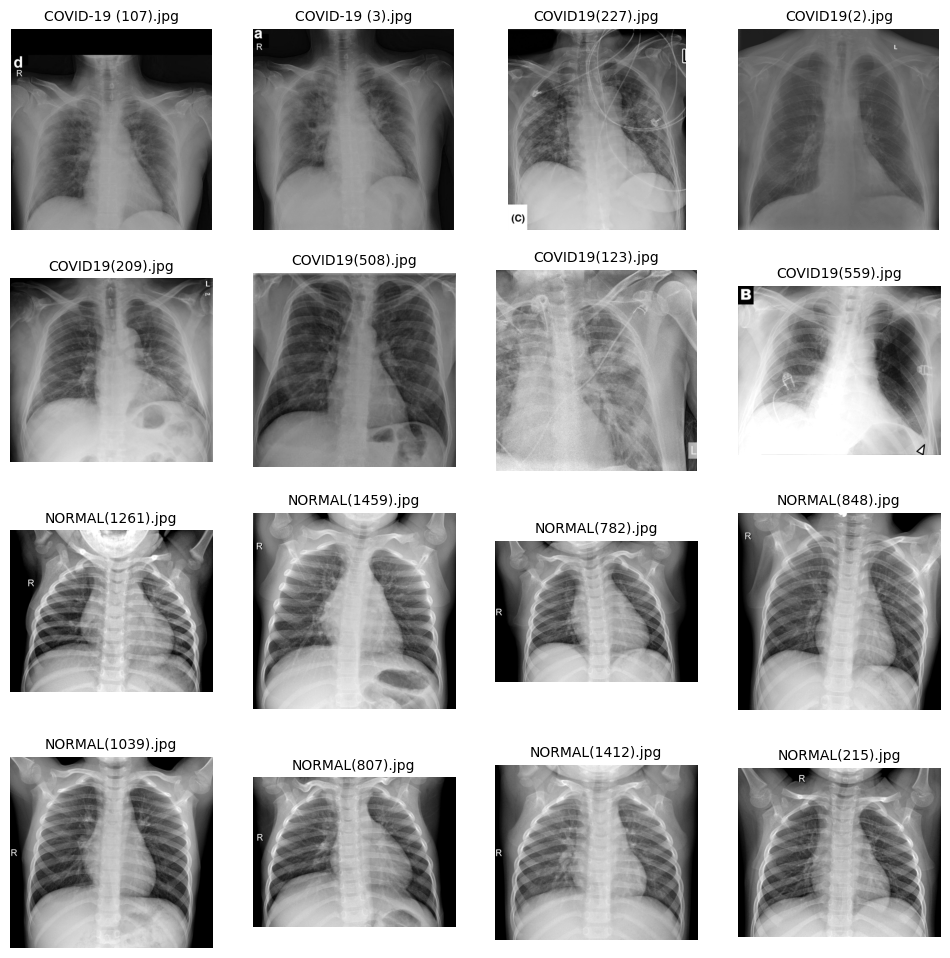

In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
rows = 4
cols = 4
fig = plt.gcf()
fig.set_size_inches(12,12)
covid_pic = [os.path.join(train_covid_dir, filename) for filename in train_covid_name[:8]]
normal_pic = [os.path.join(train_normal_dir, filename) for filename in train_normal_name[:8]]

merged_list = covid_pic + normal_pic
for i, img_path in enumerate(merged_list):
    data = img_path.split('/', 6)[6]
    sp = plt.subplot(rows, cols, i+1)
    sp.axis('off')
    img = mpimg.imread(img_path)
    sp.set_title(data, fontsize=10)
    plt.imshow(img, cmap='gray')

plt.show()

## Data Preprocessing & Augmentation

In [9]:
dgen_train = ImageDataGenerator(rescale=1./255,
                                validation_split = .2,
                                zoom_range = .2,
                                horizontal_flip = True)
dgen_test = ImageDataGenerator(rescale=1./255)

train_generator = dgen_train.flow_from_directory(train_dir,
                                                 target_size = (150,150),
                                                 subset = 'training',
                                                 batch_size = 32,
                                                 class_mode = 'binary')

validation_generator = dgen_train.flow_from_directory(train_dir,
                                                 target_size = (150,150),
                                                 subset = 'validation',
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_generator = dgen_test.flow_from_directory(test_dir,
                                               target_size = (150,150),
                                               batch_size = 32,
                                               class_mode = 'binary')


Found 1449 images belonging to 2 classes.
Found 362 images belonging to 2 classes.
Found 484 images belonging to 2 classes.


In [10]:
# get the class indices
print(train_generator.class_indices)
#get the image shape
print(train_generator.image_shape)

{'COVID19': 0, 'NORMAL': 1}
(150, 150, 3)


## Build Convolutional Neural Network Model

In [21]:
model = Sequential([
    Conv2D(32, (5,5), padding='SAME', activation='relu', input_shape=(150,150,3)),
    MaxPooling2D((2,2)),
    Dropout(.5),
    Conv2D(64, (5,5), padding='SAME', activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(.5),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(.5),
    Dense(1, activation='sigmoid')]
)

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 75, 75, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        51264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 37, 37, 64)       

## Compile & Train the Model

In [23]:
model.compile(optimizer=Adam(.001), loss = 'binary_crossentropy', metrics=['accuracy'])

In [25]:
# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,         # Reduction factor (new_lr = lr * factor)
    patience=5,
    min_lr=0.0001)


# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_generator,
    epochs=60,
    validation_data=validation_generator,
    # callbacks=[LearningRateScheduler(scheduler, verbose=1), early_stopping]
    callbacks=[lr_scheduler, early_stopping]
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/60
46/46 [==============================] - 48s 1s/step - loss: 1.5568 - accuracy: 0.6832 - val_loss: 0.4265 - val_accuracy: 0.8646 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/60
46/46 [==============================] - 41s 893ms/step - loss: 0.2779 - accuracy: 0.8903 - val_loss: 0.2144 - val_accuracy: 0.9448 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/60
46/46 [==============================] - 42s 914ms/step - loss: 0.1966 - accuracy: 0.9179 - val_loss: 0.1531 - val_accuracy: 0.9586 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/60
46/46 [==============================] - 41s 884ms/step - loss: 0.1796 - accuracy: 0.9310 - val_loss: 0.1597 - val_accuracy: 0.9558 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.

In [27]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


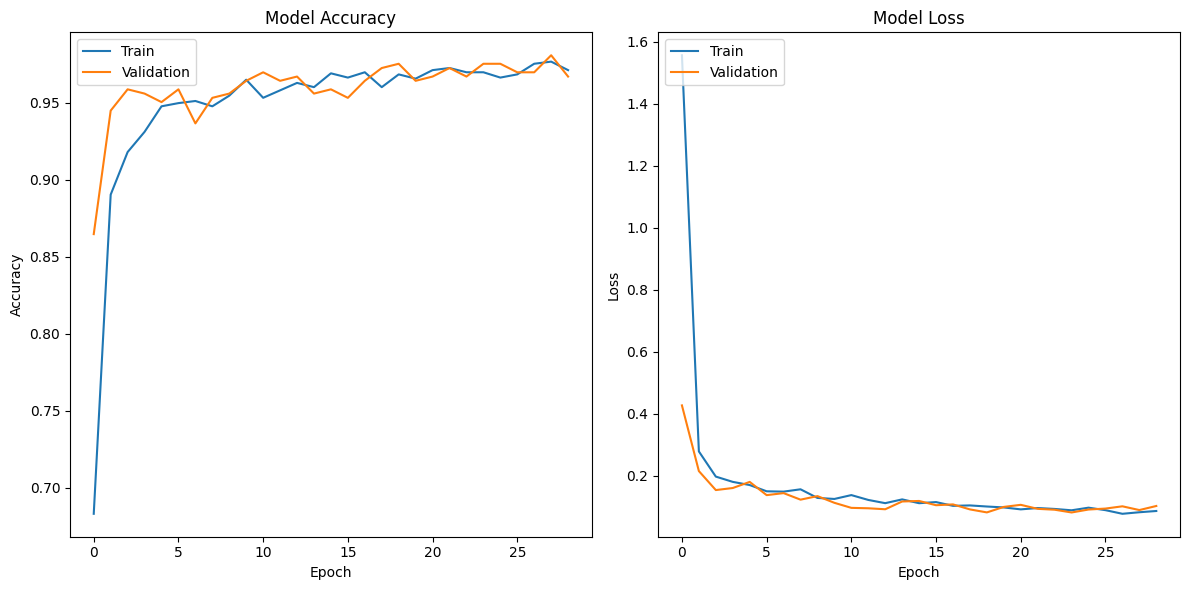

In [28]:
plot_training_history(history)


In [18]:
test_loss, test_accurary = model.evaluate(test_generator)
print(f'test loss and test accuracy: {test_loss, test_accurary}')

16/16 [==============================] - 9s 570ms/step - loss: 0.0818 - accuracy: 0.9690
test loss and test accuracy: (0.0817791000008583, 0.9690082669258118)


In [29]:
test_loss, test_accurary = model.evaluate(test_generator)
print(f'test loss and test accuracy: {test_loss, test_accurary}')

16/16 [==============================] - 9s 535ms/step - loss: 0.1001 - accuracy: 0.9649
test loss and test accuracy: (0.10009633749723434, 0.9648760557174683)
